# WOD OSD: global 1x1 bin
- annual netCDF output
- WOD OSD data
- 1965 to 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
# data source identification
# data source identification
Nlev=47
dosd='/glade/campaign/univ/ugit0034/wod18/O2/ocldb1646245120.16765_OSD'
Nosd=37

In [3]:
os.system('echo $USER > userid')
userid=np.genfromtxt('userid',dtype='<U36')
#
dirname=f'/glade/derecho/scratch/{userid}/WOD_annual_OSD/'
varname='Oxygen'
#ds=xr.open_dataset(dosd+'.nc')
#print(dirname)

In [4]:
#ds=xr.open_dataset('obs_clim/o2_clim_OI1x1_osdctd_mon_adj.nc')
#o2clim=ds.o2.to_numpy()
#
os.system('rm -rf '+dirname)
os.system('mkdir -p '+dirname)

0

In [5]:
# prepare grid cells
res=1.0
xW=np.arange(-180,180,res)
yS=np.arange(-90,90,res)
xC=np.arange(-180,180,res)+res/2
yC=np.arange(-90,90,res)+res/2
xE=np.arange(-180,180,res)+res
yN=np.arange(-90,90,res)+res
# empty array
Nx=np.size(xC)
Ny=np.size(yC)
#
#z=[   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
#        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
#       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
#       4500., 5000., 5500.]
z=np.array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.,  125.,  150.,  175.,  200.,  225.,  250.,
        275.,  300.,  325.,  350.,  375.,  400.,  425.,  450.,  475.,
        500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000.])
Nz=np.size(z)

In [6]:
def monthly_1deg_bin(Nlev,year,varname):
    # prepare array
    dd_osd=np.zeros((12,Nlev,180,360),dtype='int')
    sumX_osd=np.zeros((12,Nlev,180,360))
    dd_prof=np.zeros((12,180,360),dtype='int')
    # set 1deg lon-lat grid
    Xw=np.arange(-180,180,1)
    Ys=np.arange(-90,90,1)
    # loop over each WOD ragged netCDF file
    for f in range(Nosd):
        if f==0:
            fn=dosd+'.nc'
        else:
            fn=dosd+str(f+1)+'.nc'
        #print('processing '+fn)
        dsosd=xr.open_dataset(fn)
        # now loop over each cast in the netCDF file
        timeloc = pd.DatetimeIndex(dsosd['time'])
        Nprof0=np.size(timeloc)
        yearloc = timeloc.year
        uyear=np.unique(yearloc)
        if uyear[0]==1770:
            minyr=uyear[1]
        else:
            minyr=uyear[0]
        maxyr=uyear[-1]
        if (maxyr < year) | (minyr > year):
            note='skipping non-overlapping years...'
        else:
            print('processing '+fn)
            print('num of prof = '+str(Nprof0)+' max year = '+str(maxyr)+' min year = '+str(minyr))
            print('reading data...')
            lonloc=dsosd['lon'].to_numpy()
            latloc=dsosd['lat'].to_numpy()
            # get row size (z,T,S) are the same
            zrsize=dsosd['z_row_size'].to_numpy()
            orsize=dsosd[varname+'_row_size'].to_numpy()
            # get depth data
            zp0=dsosd['z'].to_numpy()
            # get tracer data
            o2p0=dsosd[varname].to_numpy()
            oflg0=dsosd[varname+'_WODflag'].to_numpy()
            # get month 
            monloc = timeloc.month
            zlevidx=0
            o2levidx=0
            lonloc[lonloc==-180.0]=-179.99
            for nn in range(Nprof0):
                # current year and month
                mind=int(monloc[nn])-1
                yrnow=yearloc[nn]
                # determine x,y,month grid
                xind=np.where((Xw>=lonloc[nn]-1)&(Xw<lonloc[nn]))[0][0]
                yind=np.where((Ys>=latloc[nn]-1)&(Ys<latloc[nn]))[0][0]
                # determine the number of samples in this particular profile
                o2inc=orsize[nn]
                # obtain depth of the samples
                zp1=zp0[zlevidx:int(zlevidx+zrsize[nn])]
                # check if O2 data exists
                if np.isnan(o2inc):
                    tmp_note='no data'
                else:
                    # get the profile and its quality flag
                    Nz1=int(o2inc)
                    o2p1=o2p0[o2levidx:int(o2levidx+o2inc)]
                    oflg1=oflg0[o2levidx:int(o2levidx+o2inc)]
                    o2levidx=int(o2levidx+o2inc) # update o2levidx here
                    # test
                    #if (xind==170)&(yind==145):
                    #    print(o2p1[:10])
                    #    print(oflg1[:10])
                    # vertical level limits to Nz
                    if (Nz1>Nlev):
                        Nz1=Nlev
                    for k in range(Nz1):
                        ## perform additional QC +/- 3*STD 
                        #olo=o2woa_an[mind,k,yind,xind]-3*obs_std
                        #ohi=o2woa_an[mind,k,yind,xind]+3*obs_std
                        #olo=o2woa_an[mind,k,yind,xind]-3*o2woa_sd[mind,k,yind,xind]
                        #ohi=o2woa_an[mind,k,yind,xind]+3*o2woa_sd[mind,k,yind,xind]
                        #if (o2p1[k]>=olo)&(o2p1[k]<=ohi)&(oflg1[k]==0):
                        if (oflg1[k]==0)&(yrnow==year):
                            sumX_osd[mind,k,yind,xind]=sumX_osd[mind,k,yind,xind]+o2p1[k]
                            dd_osd[mind,k,yind,xind]=dd_osd[mind,k,yind,xind]+1
                            if (k==0):
                                dd_prof[mind,yind,xind]=dd_prof[mind,yind,xind]+1
                    # --- done within profile loop
                # -------
                # now update the index for Z, T and S and go to the next profile
                zlevidx=int(zlevidx+zrsize[nn])
            # check if the number of sample matches up for the entire WOD file
            Nobs0=np.size(zp0)
            if zlevidx!=Nobs0:
                print('error! number of sample did not match')
            else:
                print('passed the sample count check')
    return sumX_osd,dd_osd,dd_prof

In [7]:
def save_1deg_bin(dsum,dd,xc,yc,zc,year,var,dprof):
    fn=dirname+'/'+var+'_1x1bin_osd_'+str(year)+'.nc'
    dave=dsum/dd
    mon=np.arange(f'{year}-01',f'{year+1}-01',dtype='datetime64[M]')
    da=xr.DataArray(data=dave,name=var,dims=['time','depth','lat','lon'],\
                coords={'time':mon,'depth':zc,'lat':yc,'lon':xc})
    ds=da.to_dataset()
    dd=xr.DataArray(data=dd,name='sample_count',dims=['time','depth','lat','lon'],\
                    coords={'time':mon,'depth':zc,'lat':yc,'lon':xc})
    ds['sample_count']=dd
    ddp=xr.DataArray(data=dprof,name='profile_count',dims=['time','lat','lon'],\
                    coords={'time':mon,'lat':yc,'lon':xc})
    ds['profile_count']=ddp
    ds.to_netcdf(fn)
    return 1

In [8]:
YR=np.arange(1965,2021,1)
#
xc=xC.copy()
yc=yC.copy()
zc=z.copy()
#
for yr in YR:
    print('=== working on '+str(yr)+' ===')
    sumX,dd,dprof=monthly_1deg_bin(Nlev,yr,varname)
    dummy=save_1deg_bin(sumX,dd,xc,yc,zc,yr,varname,dprof)

=== working on 1965 ===
processing /glade/campaign/univ/ugit0034/wod18/O2/ocldb1646245120.16765_OSD9.nc
num of prof = 69441 max year = 1965 min year = 1963
reading data...
passed the sample count check
processing /glade/campaign/univ/ugit0034/wod18/O2/ocldb1646245120.16765_OSD10.nc
num of prof = 67692 max year = 1966 min year = 1965
reading data...
passed the sample count check
=== working on 1966 ===
processing /glade/campaign/univ/ugit0034/wod18/O2/ocldb1646245120.16765_OSD10.nc
num of prof = 67692 max year = 1966 min year = 1965
reading data...
passed the sample count check
processing /glade/campaign/univ/ugit0034/wod18/O2/ocldb1646245120.16765_OSD11.nc
num of prof = 66300 max year = 1968 min year = 1966
reading data...
passed the sample count check
=== working on 1967 ===
processing /glade/campaign/univ/ugit0034/wod18/O2/ocldb1646245120.16765_OSD11.nc
num of prof = 66300 max year = 1968 min year = 1966
reading data...
passed the sample count check
=== working on 1968 ===
processing

KeyboardInterrupt: 

In [13]:
ds=xr.open_mfdataset(dirname+varname+'_1x1bin_osd_*.nc')

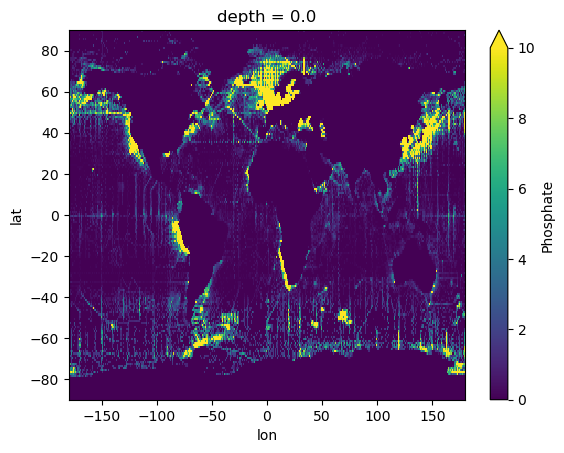

In [16]:
ds[varname].isel(depth=0).sum('time').plot(vmax=10)

In [17]:
ds.to_netcdf('/glade/campaign/univ/ugit0034/wod18/'+varname+'_1x1bin_osd_1965-2020.nc')

In [18]:
ds

,Array,Chunk
Bytes,15.25 GiB,278.83 MiB
Shape,"(672, 47, 180, 360)","(12, 47, 180, 360)"
Count,168 Tasks,56 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 GiB,278.83 MiB
Shape,"(672, 47, 180, 360)","(12, 47, 180, 360)"
Count,168 Tasks,56 Chunks
Type,int64,numpy.ndarray
,Array,Chunk


In [20]:
ds.time

<xarray.DataArray 'time' (time: 672)>
array(['1965-01-01T00:00:00.000000000', '1965-02-01T00:00:00.000000000',
       '1965-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1965-01-01 1965-02-01 ... 2020-12-01